<a href="https://colab.research.google.com/github/ThiagoMueller/csci2470labs/blob/main/2470_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS1470 Lab 4: Visualizing & Debugging CNNs

In this lab, you will visualize the information contained in the layers of a trained convolutional neural network. Then, you will debugged a faulty CNN model for MNIST to improve it's accuracy. Finally, you will explore an input optimizer, which is a model which produces optimal inputs for a given model to help interpret the model prediction strategy.

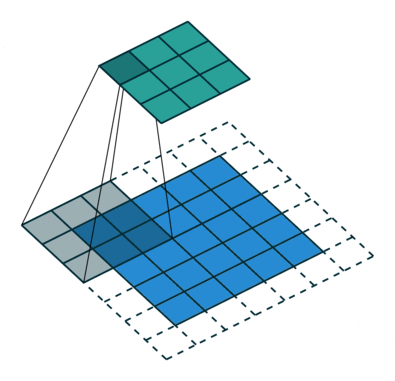

In [ ]:
## Data augmentation in Tensorflow>=2.9 has been... problematic for some reason.
## Downgrading to 2.8.3 just to make it faster.
## https://stackoverflow.com/a/73751638/5003309
!pip install tensorflow-gpu==2.8.3

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image   ## Python Image Library. Very Useful
import io

from tqdm import tqdm   ## For nice progress bars
import IPython.display  ## For displaying images generated in your lab

import skimage
import skimage.io
import numpy as np
print(tf.__version__)

mpl.rcParams['figure.figsize'] = [8, 8] ## Default mpl figure size

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.5/498.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 46.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2

2.8.3


# **VGG16**
In this lab, we will be analyzing Visual Geometry Group's (VGG) 16 layer convolutional neural network. The network was trained on ImageNet, a dataset of over 14 million images with 1000 different classes.

![alt text](https://miro.medium.com/max/1400/1*NNifzsJ7tD2kAfBXt3AzEg.webp)

Image from: https://medium.com/mlearning-ai/an-overview-of-vgg16-and-nin-models-96e4bf398484

It has over 100 million parameters, so it would take a very long time to train on a SunLab machine (many many days). Luckily, Keras has the weights built in, so we can simply load the model as well as its weights like so:

In [ ]:
if 'vgg_model' not in globals():        ## Don't download it again
    vgg_model = tf.keras.applications.vgg16.VGG16(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000
    )

553476096/553467096 [==============================] - 7s 0us/step


What exactly is going on inside this network? A valuable way to debug/analyze a network is to look at intermediate layers' outputs. Fortunately, Keras makes it easy with some nice functionality provided by its `Model` class. Make sure to run the next cell, as you'll need information from its output for the rest of this section.

In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

###**[Check-Off 1]**: Describe the model's architecture!###
1. For `block1_conv1`, is SAME or VALID padding used? How do you know?

2. Assuming the first max pooling layer has filters of shape `(2, 2)`, what are the strides? How can you tell?

Once you've figured out these answers, explain them to your lab TA.

# **TASK 1:** Visualizing Layer Outputs##

Run the cell below to see the input image we will be using for this task.
**You will need to import custom images of your own later in this lab so take note of this code!**

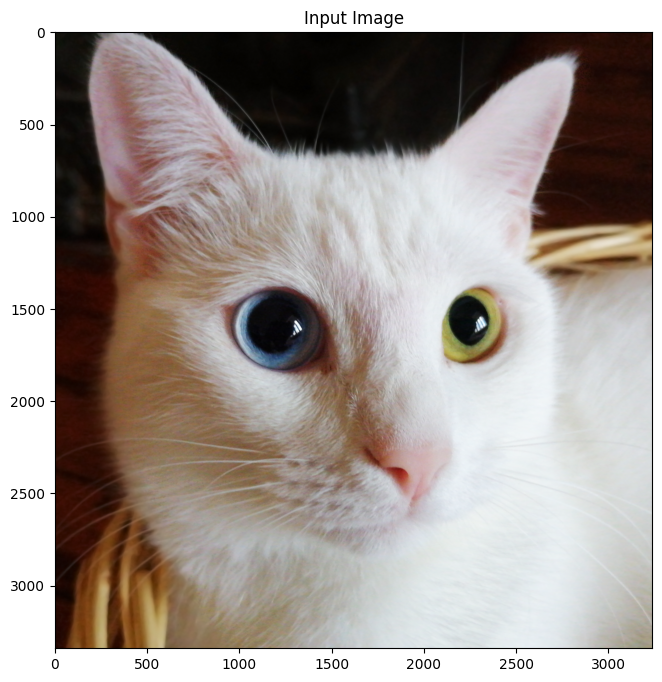

In [ ]:
## In colab, you can call bash commands using "!"
## wget downloads file from a url. -O specifies out filename, -q makes it quiet
!wget https://upload.wikimedia.org/wikipedia/commons/b/b1/VAN_CAT.png -O kitty.jpg -q

cat_img = Image.open('kitty.jpg')
cat_img = cat_img.crop((300, 200, cat_img.width - 300, cat_img.height - 300))

plt.imshow(cat_img)
plt.title('Input Image')
plt.show()

### **NOTE**:
 - Cat is a valid category of the ImageNet training set.
 - The cat has prominent features such as eyes, nose, and ears.
 - Background contrasts sharply with the cat.

These qualities make this picture a good candidate to see what our network can detect.

### **[Check-Off 2]** - Intermediate Layers

1. Fill in the cell and TODOs below to view some of the output of the `block1_conv1` for the image of the cat. What features in the image are the filters responding to?

2. Now change it to view the ouput of `block3_pool`, how do the activations differ?

3. Then, look at `block5_pool`. Find a couple feature sets where you can think of what parts of the image are causing this activation.

You should have your responses to all parts in this checkoff before calling over your TA to get checked off.

In [ ]:
## TODO: Resize your image so it matches the input size of VGG16
## HINT: cat_img is currently a PIL Image, which has resize (and is NOT an np.array)
cat_input = ??
cat_input = ??

show_img = True            ## TODO: Toggle for low-res layers to see cat overlay
layer_name = ??                                       ## TODO: Replace layer name
curr_layer = vgg_model.get_layer(layer_name).output   ## Retrieves layer by name

## Recall this model argument scheme subsets or chains models together
## by considering the path going along the input and output references.
slice_model  = tf.keras.Model(inputs=vgg_model.input, outputs=curr_layer)
slice_output = slice_model.predict(cat_input[None,:,:,:])

## fig is the plot as a whole
## axes is a list of references to the individual plots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(24,24))

for i in range(64):
    curr_ax = axes[i//8, i%8]
    out = slice_output[0,:,:,i].astype(np.uint8)

    if show_img:
        ## Adds in the image for visual reference by resizing logits to
        ## img size and outputing original image with lower alpha (opacity)
        out = Image.fromarray(out)
        out = out.resize(cat_input.shape[:-1], resample=Image.BOX)
        curr_ax.imshow(cat_input, alpha=0.4)

    curr_ax.imshow(out)     ## Add the image to current axis

SyntaxError: invalid syntax (<ipython-input-5-fec7937825e3>, line 3)

Now pick an image of choice from the internet and run it through the network. Fill in the TODOs below (your code will be very similar to the code we provided above). Plot the intermediate outputs as you did before.

In [ ]:
## TODO: Import your own custom image here using wget

def visualize_vgg_layer(img, layer_name, nrows, ncols, figsize, view_img=True):
    img = img.resize((224,224))
    img = np.array(img)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    curr_layer = vgg_model.get_layer(layer_name).output
    slice_model  = tf.keras.Model(inputs=vgg_model.input, outputs=curr_layer)
    slice_output = slice_model.predict(img[None,:,:,:])

    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            curr_ax = axes[row, col]
            out = slice_output[0,:,:,idx].astype(np.uint8)
            out = Image.fromarray(out)
            out = out.resize(img.shape[:-1], resample=Image.BOX)
            curr_ax.imshow(out)
            if view_img:
                curr_ax.imshow(img, alpha=0.3)

    return fig, axes


# TODO: Read in image. Crop if necessary
img2 = Image.open('img2.jpg')
# img2 = img2.crop((200, 200, img2.width - 200, img2.height - 200))

## TODO: Fill in layer name here, should be the same as above
visualize_vgg_layer(img2, '', 6, 6, (15,15));

###**[Check-Off 3]** - Any surprises?###

How do these filter outputs compare to the filter outputs from the cat? Show these outputs to your TA and describe some things you notice.

# Models Have Low-Level Filters... Like Sobel Edges

Now, we'll be looking at a common filter that is used to detect edges for images. The Sobel operator is used in edge detection to create a resulting image emphasizing certain edges (do not confuse this with the Prewitt operator, which is very similar). TensorFlow has [a nice function](https://www.tensorflow.org/api_docs/python/tf/image/sobel_edges) that easily allows us to apply a Sobel filter to an image. The following code applys a Sobel filter to the cat image!


In [ ]:
# Read in image of choice
image = skimage.img_as_float(skimage.io.imread('https://drive.google.com/uc?export=view&id=1-kzXYmHEr5a5M4AzCEez8_y3F_t7ZS93'))
image = tf.expand_dims(image, 0)

# Apply TensorFlow sobel edge filter
sobel_result = tf.image.sobel_edges(image)

# Get the Sobel edges in horizontal and vertical directions
sobel_h = sobel_result[0, :, :, :, 0]  #  Horizontal edges
sobel_v = sobel_result[0, :, :, :, 1]  #  Vertical edges

# Creates plot with 2 columns and figure size of 20 by 20.
fig, axs = plt.subplots(ncols=2, figsize=(20,20))
axs[0].imshow(sobel_h, cmap="Greys")
axs[1].imshow(sobel_v, cmap="Greys")
plt.show()

Notice that the first output detects horizontal edges and lines, while the second output detects vertical edges and lines.

<!-- 2. Why would it make sense for the earlier stages of a CNN to learn a filter like this?

One explanation is that earlier stages of the network are best served learning lower level hierarchical features like edges and gradients, so that later layers can learn more advanced features like faces, limbs, wings, etc. that are the product of activations from things like edges and gradients. -->
Now, let's consider what a simple vertical edge detecting filter might look like:

If our filters were 3 by 3 matrices of values, the vertical edge detector may have a matrix that looks like this:

      1 0 -1  
      1 0 -1  
      1 0 -1  

This is because multiplying this filter over an image will produce a high output value ONLY IF there is a large difference in pixel value between the three pixels on the left and the three pixels on the right. When would this happen? If there is some vertical edge that separates two distinct sections of the image (for example the right edge of each ear in the cat image which separates the ear from the background)!

<!--
###Checkoff 4###

1. What are some of the differences between your first and second outputs?
2. Given a 3 by 3 matrix of values, what do you think might be some values that produce a vertical edge detector? Tell your TA your thoughts and why - we just want to get you thinking!
3. Explain how strides and padding work in the gif of convolution below. How would we loop through indices of the image and the kernel to produce this effect? -->

# **Task 2:** Debugging CNN
So far, we've just been visualizing a pre-trained CNN model. Maybe it's time to train a model ourselves! To help you all out, we tried our hardest to make an example by making an MNIST classifier just like your assignments. However, something went wrong and the model seems to perform worse than what we expected.

Your task is to fix the model below ***without changing number of trainable parameters***. The validation accuracy for the correct model should be no lower than 95%.

### **Note:**
 - Remember what operations do not add more parameters to the model.
 - You may notice that validation accuracy is much higher. This is because the training accuracy for one epoch includes a lot of batches for which the network was undertrained. The performance on the validation set should reflect the predictive power of the model near the end of the epoch.

In [ ]:
# Loading in and preprocessing the data *the manual way* because why not...
mnist = tf.keras.datasets.mnist
(X0, Y0), (X1, Y1) = mnist.load_data()
X0 = tf.cast(X0, tf.float32) / 255.0
X1 = tf.cast(X1, tf.float32) / 255.0

# Making our labels one hot vectors
Y0 = tf.one_hot(Y0, 10, dtype=tf.float32)
Y1 = tf.one_hot(Y1, 10, dtype=tf.float32)

print(f'X0 = {X0.shape, X0.dtype}, Y0 = {Y0.shape, Y0.dtype}')

In [ ]:
# TODO: Fix me!
class DigitModel(tf.keras.Model):

    def __init__(self, **kwargs):
        """
        The model class inherits from tf.keras.Model.
        It stores the trainable weights as attributes.
        """
        super().__init__(**kwargs)

        def make_variables(*dims, initializer=tf.random.normal):
            ## *dims takes all unnamed variables and condenses to dims list
            return tf.Variable(initializer(dims, stddev=.1))

        ## Initialize your variables (weights) here:
        ## Recall: input size=784 (# pixels) and output size=10 (# classes)
        self.filter1 = make_variables(3, 3,  1, 32)
        self.filter2 = make_variables(3, 3, 32, 64)
        self.filter3 = make_variables(3, 3, 64, 64)
        self.W1      = make_variables(4*4*64, 10)
        self.b1      = make_variables(10)

        self.flatten = tf.keras.layers.Flatten()

    @staticmethod
    def conv_step(x, filter, conv_args, act_fn=tf.identity, pool_fn=tf.identity):
        out = tf.nn.convolution(x, filter, **conv_args)
        out = act_fn(out)
        out = pool_fn(out)
        return out

    def call(self, inputs):
        """
        Forward pass, predicts labels given an input image using fully connected layers
        :return: the probabilites of each label
        """

        ### POSSIBLE EXPANSION OF FOLLOWING if using relu and avg_pool
        ## l1_out = tf.nn.convolution(inputs, self.filter1, strides=1, padding='SAME')
        ## l1_out = tf.nn.relu(l1_out)
        ## l1_out = tf.nn.avg_pool(l1_out, 2, 2, padding='SAME')
        ## ...

        conv_args = {'strides' : 1, 'padding' : 'SAME'}
        conv_fns  = {       ## Something's wrong here...
            'act_fn'  : tf.nn.relu,
            'pool_fn' : lambda l: tf.nn.avg_pool(l, 2, 2, padding='SAME')
        }

        l1_out = self.conv_step(inputs, self.filter1, conv_args, **conv_fns)
        l2_out = self.conv_step(l1_out, self.filter2, conv_args, **conv_fns)
        l3_out = self.conv_step(l2_out, self.filter3, conv_args, **conv_fns)

        ## Keras has dynamic batch size, so the normal way of getting
        ## batch dim doesn't work when we use keras fit.
        ## For this, we'll have to use the keras flatten layer.
        # l3_out = tf.reshape(l3_out, [l3_out.shape[0], -1]) ## <- Incorrect way
        l3_out = self.flatten(l3_out)

        ## Somethings wrong here...
        logits = tf.nn.relu(tf.matmul(l3_out, self.W1) + self.b1)
        prbs = tf.nn.softmax(logits)

        return prbs


# Instantiate our model
model = DigitModel()

# loss_fn = lambda y, p: tf.keras.losses.binary_crossentropy(y, p)
# acc_fn  = lambda y, p: tf.reduce_mean(tf.keras.metrics.categorical_accuracy(y, p))

model.compile(
    optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss        = tf.keras.losses.CategoricalCrossentropy(),
    metrics     = [tf.keras.metrics.CategoricalAccuracy()]
)

print(f'Input shape: {X0[:,:,:,None].shape}\t[B, H, W, C]')
print(f'Label shape: {Y0.shape}\t[B, N]')

model.fit(
    X0[:,:,:,None], Y0,
    epochs = 1,
    batch_size = 256,
    validation_split = 0.5  ## Auto-splits dataset into train/valid subsets
)

assert model.count_params() == 3*3*32 + 3*3*32*64 + 3*3*64*64 + 1024*10 + 10, \
    'ERROR: You have changed the number of trainable parameters in the model'

### **[Check-Off 4]**: Accuracy > 97% on validation set.
What did you change in the model architecture? How do your changes effect the accuracy of the model?

# **TASK 3:** Input Optimization

So far, we've been training models that tune their internal parameters in order to map a relationship. Hopefully you're starting to realize just how powerful this can be and what kinds of things this can be useful for. However, recall that we can really optimize anything using a similar strategy if we really needed to... so why don't we do that?

A pretty common issue with deep learning models is a lack of interpretability; it's difficult to understand what the model is doing to make its decisions by just looking at its internals, so explanation techniques often have to be leveraged to derive this insight.

We're going to finish off the lab by setting up an **input optimizer**! Specifically, we're going to create a routines that optimized inputs for our MNIST model that classify as each of the possible output classes.

A lot of the code has already been provided for you below! Your task is to finish it up!

### **HINTS**:

 - Implement the optimization step of the algorithm.
    - Since we don't want users to specify inputs and outputs to train on per se, `fit` and `train_step` might not be so appropriate. Instead, we're going to create a `train` method which will just take in an epoch count and do the training for it.
    - Do the augmentation step once per epoch, and remember that the augmentation should be differentiable (thanks Tensorflow).
    - Instead of optimizing the weights, make sure to optimize the inputs.
    - Remember that the `gradient` and `apply_gradient` steps require a *list* of things to optimize with respect to...

 - This technique can be very unstable due to the plethora of local minima present in these kinds of problems. To help offset this, we are going to use **data augmentation** techniques to move around our optimized inputs during the training phase. And by we, I mean you!
   - Recall that we could normalize using a Normalization layer and one-hot encode using a CategoryEncoder layer, so why can't we do the same for augmentation? Implement the optimizer's `augment` function with a pair of layers that randomly zoom and randomly translate the images. Keep the augmentation light (i.e. 10% - 20% shifting in either direction along the vertical and horizontal).
     - Some useful things may include Keras's `RandomZoom` and `RandomTranslation` layers.
     - I believe there was some kind of a sequential specification that could combine layers easily...


 - This script comes with visualization utilities that we will use to see how the training goes! Feel free to borrow them for later use, and don't worry about understanding them for right now. Just enjoy the GIF.

In [ ]:
class InputOptimizer(tf.keras.Model):
    '''
    Optimizes inputs for a model
    '''
    def __init__(self, model, input_shape, output_shape, **kwargs):
        """
        Default constructor: Takes in a model to optimize for and example
        input/output shapes of the model.
        """
        super().__init__(**kwargs)

        ## Save the model for which the inputs will be optimized for
        self.model = model

        self.num_probs = output_shape[1]                    ## 10
        self.opt_shape = [self.num_probs] + input_shape[1:] ## 10x28x28x1

        ## Set of optimizable inputs; 10 28x28 images initialized to 0.
        self.opt_input = tf.Variable(tf.zeros(self.opt_shape))

        ## Predictions to which our inputs are optimized for. nxn "eye"-dentity mtx
        self.opt_probs = tf.Variable(tf.eye(self.num_probs))

        ## Images of the optimization process to be exported as a gif
        self.opt_imgs = []


    @staticmethod
    def fig2img(fig):
        """
        Convert a Matplotlib figure to a PIL Image and return it
        https://stackoverflow.com/a/61754995/5003309
        """
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        return img


    def add_input_to_imgs(self, outputs, nrows=2, ncols=5, figsize=(10, 5)):
        '''
        Plot the image samples in outputs in a pyplot figure and add the image
        to the 'opt_imgs' list. Used to later generate a gif.
        '''
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for i, ax in enumerate(axs.reshape(-1)):
            ax.set_title(f'Ideal for {i}')
            out_numpy = np.squeeze(outputs[i].numpy(), -1)
            ax.imshow(out_numpy, cmap='Greys')
        self.opt_imgs += [self.fig2img(fig)]
        plt.close(fig)


    # ## FOR REFERENCE: FEEL FREE TO COPY & MODIFY, BUT DO NOT UNCOMMENT
    # def train_step(self, data):
    #     '''
    #     Optional Train_Step Specification; This happens for every training bach
    #     Uncomment this if you want to customize something
    #     https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    #     '''
    #     x, y = data
    #     with tf.GradientTape() as tape:
    #         y_pred = self(x, training=True)  # Forward pass
    #         # Compute the loss value (the loss function is configured in `compile()`)
    #         loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

    #     # Compute gradients
    #     gradients = tape.gradient(loss, self.trainable_variables)
    #     # Update weights
    #     self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    #     # Update metrics (includes the metric that tracks the loss)
    #     self.compiled_metrics.update_state(y, y_pred)
    #     # Return a dict mapping metric names to current value
    #     return {m.name: m.result() for m in self.metrics}


    def train(self, epochs, augment_fn=tf.identity):
        '''
        Optional Train_Step Specification; This happens for every training batch
        Uncomment this if you want to customize something
        https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
        '''
        pbar = tqdm(range(epochs))    ## Loop with nice progress bar/description
        for e in pbar:

            ## TODO:

            ## 1. Create a tape scope in which you augment the inputs, get the
            ##      predictions, and compute the loss.

            ## 2. Optimize for the output loss with respect to the *inputs*
            ##      HINT: gradient and apply_gradient expect a *list* of vars...

            ## Augment the images and add them to the list of output pics
            self.add_input_to_imgs(augment_fn(self.opt_input))

            ## Compute eval metric (how often optimized inputs classified right)
            out = {m.name: m.result() for m in self.metrics}
            acc = round(float(out["categorical_accuracy"]), 3)
            pbar.set_description(f'Epoch {e+1}/{epochs}: Accuracy {acc}\t')

        return out


## TODO: Augmentation pipeline to zooms and translates the images
augment_fn = tf.identity

# Instantiate our model
input_opt_model = InputOptimizer(
    model,
    input_shape  = X0[:,:,:,None].shape,
    output_shape = Y0.shape
)

input_opt_model.compile(
    optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss        = tf.keras.losses.CategoricalCrossentropy(),
    metrics     = [tf.keras.metrics.CategoricalAccuracy()],
    run_eagerly = True    ## We want to convert our tensors to numpy, so...
)

input_opt_model.train(epochs=50, augment_fn=augment_fn);

Once training is complete, create the gif and display it using the following utility:

In [ ]:
imgs = input_opt_model.opt_imgs
imgs[0].save('ideal_inputs.gif', save_all=True, append_images=imgs[1:], loop=True, duration=200)
IPython.display.Image(open('ideal_inputs.gif','rb').read())

### **[Check-Off 5]**: Discussion

Do these optimized inputs make sense? What about the structure of the network (or the structure of our optimizer) makes these look like that? Discuss with your TA! Feel free to discuss some of the following:

- Why do there seem to be repeating line segments in the optimized inputs?
- This process will almost always fail when the inputs are not augmented; the inputs converging to a plethora of random pixels with various intensities, but the accuracy will still increase up to 90% or more. What does that say about our MNIST model?
- Do you think there are any good ways of making the inputs less blurry or to get them to converge to the original images.

Let us know if you have any other questions about CNNs!

## Acknowledgements & Sources ##

This lab is written by Tim Ossowski, Rohin Bhushan, and Gene Siriviboon, with edits by the HTAs.

**[S'22]** Vadim Kudlay [HTA], John Fey, and David Inho Lee revised the lab to use Keras's fit loop and added the input optimizer section.